<a href="https://colab.research.google.com/github/adarsh-nl/Mineral-deposits-feature-learning-using-Autoencoder/blob/main/classification_pixelWise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 94.4 MB/s eta 0:00:00


Accuracy for fold 1: 0.6617647058823529
Accuracy for fold 2: 0.6716417910447762
Accuracy for fold 3: 0.34328358208955223
Accuracy for fold 4: 0.6716417910447762
Accuracy for fold 5: 0.6567164179104478
Mean Accuracy: 0.6010096575943811
Overall Accuracy: 0.7142857142857143
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       224
           1       0.83      0.18      0.29       112

    accuracy                           0.71       336
   macro avg       0.77      0.58      0.56       336
weighted avg       0.75      0.71      0.65       336



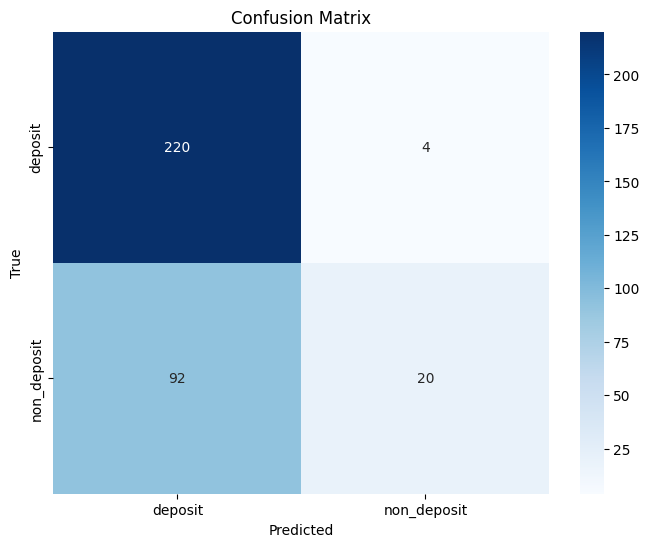

In [3]:
import os
import random
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

# Define the paths
label_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/Dep_NonDepFinal.tif"
stitched_images_dir = "/content/drive/MyDrive/IITB/Magntic_Image/stitched_outputs_v1"

# Open the label image using rasterio
with rasterio.open(label_image_path) as label_dataset:
    # Read the label image as a numpy array
    label_image = label_dataset.read(1)  # Assuming label is in the first band

# Define the classes and corresponding pixel values
class_labels = {
    "deposit": 1,
    "non_deposit": 0
}

# Define the sample size
sample_size = 12

# Initialize lists to store the sampled positions, pixel values, and labels
samples = []
pixel_values = []
labels = []

# Iterate over the label image and sample positions
for y in range(label_image.shape[0]):
    for x in range(label_image.shape[1]):
        pixel_value = label_image[y, x]
        if pixel_value in class_labels.values():
            samples.append((x, y))

# Randomly select sample positions
selected_samples = random.sample(samples, sample_size)

# Iterate over the selected samples
for (x, y) in selected_samples:
    # Get the pixel values at the same location for all stitched images
    pixels = []
    for image_name in os.listdir(stitched_images_dir):
        stitched_image_path = os.path.join(stitched_images_dir, image_name)
        stitched_image = Image.open(stitched_image_path)
        pixel_value = stitched_image.getpixel((x, y))
        pixels.append(pixel_value[0])  # Take only the first pixel value

    # Append the pixel values and label to the lists
    pixel_values.extend(pixels)
    labels.extend([label_image[y, x]] * len(pixels))  # Append the label value for each pixel

# Convert the pixel values and labels to arrays
X = np.array(pixel_values)
y = np.array(labels)

# Create the SVM classifier
classifier = svm.SVC()

# Perform k-fold cross-validation
k = 5  # Set the number of folds
accuracy_scores = cross_val_score(classifier, X.reshape(-1, 1), y, cv=k)

# Print the accuracy for each fold
for fold, accuracy in enumerate(accuracy_scores):
    print(f"Accuracy for fold {fold+1}: {accuracy}")

# Calculate the mean accuracy across all folds
mean_accuracy = accuracy_scores.mean()
print("Mean Accuracy:", mean_accuracy)

# Fit the classifier to the entire training data
classifier.fit(X.reshape(-1, 1), y)

# Test the classifier and print accuracy
y_pred = classifier.predict(X.reshape(-1, 1))

# Calculate accuracy
accuracy = (y_pred == y).mean()
print("Overall Accuracy:", accuracy)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


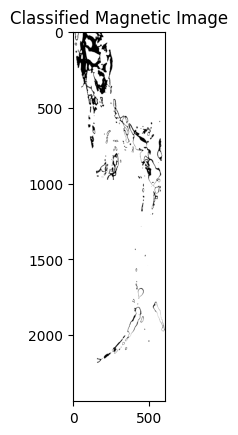

In [8]:
import numpy as np
import rasterio
from PIL import Image

# Load the magnetic image
magnetic_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/MagneticImage.tif"
with rasterio.open(magnetic_image_path) as magnetic_image_dataset:
    magnetic_image = magnetic_image_dataset.read(1)

# Create a new image of the same dimensions as the magnetic image to store the classified labels
classified_image = np.zeros_like(magnetic_image, dtype=np.uint8)

# Iterate over all pixels of the magnetic image
for y in range(magnetic_image.shape[0]):
    for x in range(magnetic_image.shape[1]):
        # Get the pixel value
        pixel_value = magnetic_image[y, x]

        # Classify the pixel using the trained SVM classifier
        label = classifier.predict([[pixel_value]])[0]

        # Assign the label (0 or 1) to the corresponding position in the classified image
        classified_image[y, x] = label

# Display the newly created image
plt.imshow(classified_image, cmap='binary')
plt.title("Classified Magnetic Image")
#plt.colorbar()
plt.show()


In [18]:
import os
import rasterio

# Define the path for the magnetic image
magnetic_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/MagneticImage.tif"

# Open the magnetic image dataset
with rasterio.open(magnetic_image_path) as magnetic_image_dataset:
    # Create a new raster dataset for the classified image
    profile = magnetic_image_dataset.profile
    profile.update(dtype=rasterio.uint8, count=1, nodata=0)  # Set nodata to 0

    # Define the output directory for the classified image
    output_dir = "/content/drive/MyDrive/IITB/Magntic_Image/classified_images"
    os.makedirs(output_dir, exist_ok=True)

    # Define the output path for the classified image
    output_path = os.path.join(output_dir, "pixelwise_classified_image.tif")

    # Invert the pixel values
    inverted_image = 1 - classified_image

    # Write the inverted image to the output path as TIFF
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(inverted_image, 1)


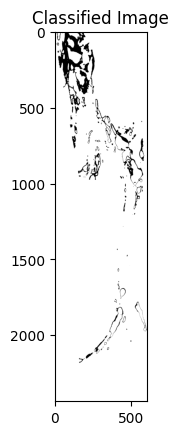

In [19]:
import rasterio
import matplotlib.pyplot as plt

# Define the path to the classified image
classified_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/classified_images/pixelwise_classified_image.tif"

# Open the classified image using Rasterio
with rasterio.open(classified_image_path) as src:
    # Read the classified image as a numpy array
    classified_image = src.read(1)

    # Display the classified image
    plt.imshow(classified_image, cmap='gray')
    plt.title('Classified Image')
    #plt.colorbar()
    plt.show()


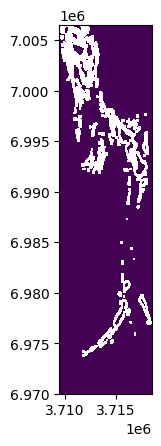

In [20]:
import rasterio
from rasterio.plot import show

# Define the path for the classified image
classified_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/classified_images/pixelwise_classified_image.tif"

# Open the classified image dataset
with rasterio.open(classified_image_path) as classified_image_dataset:
    # Display the classified image
    show(classified_image_dataset)
